<a href="https://colab.research.google.com/github/virb30/data_science/blob/master/notebooks/010_Forecasting_em_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Séries Temporais com o Prophet

Neste projeto faremos a previsão relacionada ao desfecho de animais em um abrigo. Utilizaremos a ferramenta ***Prophet*** (do Facebook) para trabalhar com séries temporais.

## *Forecasting*

***Forecasting*** ou previsão é uma tarefa comum em *Data Science*, porém altamente complexa. Devido à sua complexidade, realizar previsões confiáveis e de boa qualidade em séries temporais é uma tarefa desafiadora para a maioria dos analistas de dados, uma vez que exige conhecimentos avançados e domínio sobre as séries temporais.

Diante disso, a utilização de *frameworks* pode auxiliar na realização de previsões eficiente, mesmo que o analista não possua profundo conhecimento sobre a série.

## O Prophet
<p>
<img width="100" src="https://raw.githubusercontent.com/virb30/data_science/master/img/prophet-icon.jpg" />
</p>

O ***Prophet*** é um *framework open-source* do **Facebook**, utilizado para realizar previsões (*forecasting*) em séries temporais (*Time Series*). Disponível para Python e R, ele é capaz de realizar previsões de maneira eficiente e automatizada.

<p align="center">
<img width="600" src="https://raw.githubusercontent.com/virb30/data_science/master/img/prophet_example_for_post.png" />
</p>

Devido à variedade de séries temporais, nem todos os problemas envolvendo *time series* podem ser resolvidos da mesma maneira - e como o ***prophet*** foi pensado para resolver problemas específicos do **Facebook** - ele é muito eficiente para lidar com séries temporais que possuam:

*  Observações horárias, diárias ou semanais com pelo menos alguns meses (preferencialmente um ano) de histórico;
*  Sazonalidades, em escala humana, fortes e destacadas (dia da semana ou período do ano);
*  Feriados ou datas importantes previamente conhecidos; e
*  Tendência de crescimento não linear que se aproximam de um limite.


### Modelo de Previsão do Prophet

O ***prophet*** utiliza um modelo de séries temporais decomposto com três componentes principais: tendência, sazonalidade e feriados, combinados na equação:

$$
  y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

Onde:
* $g(t)$ é a função da tendência que modela mudanças não-periódicas na *time series*;
* $s(t)$ representa mudanças periódicas e;
* $h(t)$ representa os efeitos de feriados que ocorrem irregularmente

O erro $\varepsilon_t$ representa quaisquer mudanças não capturadas pelo modelo (assume-se que é normalmente distribuído).

Os parâmetros *default* do ***prophet*** atendem a maioria dos casos. Caso não haja um *fit* adequado do modelo - e devido a sua abordagem *analyst-in-the-loop* - é possível ajustá-los manualmente.

## O Problema de um Abrigo de Animais

O [*Austin Animal Center*](https://www.austintexas.gov/content/austin-animal-center), no Texas, provê abrigo a mais de 16.000 animais anualmente, além de serviços de proteção de animais, independentemente de espécie, raça, idade ou condições de saúde.

O objetivo é "destinar todos os animais adotáveis a lares permanentes através de adoções, assistência social ou grupos de resgate parceiros".

Infelizmente, não é possível conseguir um lar para todos os animais, e alguns precisam ser sacrificados. Com seu plano "Sem mortes" o Centro Animal de Austin visa atingir um desfecho positivo, ou seja a saída com vida desses animais, superior a 90% do total.

Neste projeto, iremos analisar o desfecho positivo desses animais de modo a identificar padrões e realizar previsões em relação ao número de saídas do *Austin Animal Center* e que possam auxiliar no planejamento de:

1. Compras de insumos (remédios, comida, etc);
2. Contratação de funcionários e colaboradores; e
3. Realização de campanhas visando otimizar a adoção de animais.


### Aquisição dos dados

Os dados foram disponibilizados pelo Austin Animal Center, no Texas. E estão disponíveis no [*City of Austin open data portal*](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)

Esse *dataset* possui aproximadamente **126k linhas** e **12 colunas** e sua última atualização data de 01 de maio de 2021, onde cada linha possui um desfecho por animal por encontro.


In [ ]:
# importar as bibliotecas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# importar prophet e bibliotecas de validação
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# melhorar a resolução dos gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
# importar os dados para um DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/virb30/data_science/master/datasets/austin_animal_outcomes.csv')

# converter a coluna DateTime para o datetime
df.DateTime = pd.to_datetime(df.DateTime)

#ver as 5 primeiras entradas
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,2020-08-16 11:38:00,08/16/2020 11:38:00 AM,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


## Análise exploratória

Esse *dataset* possui informações relevantes sobre desfecho dos animais, tais como data, tipo e subtipo de saída, além de conter informações sobre o animal, tais como tipo, sexo, idade, raça, cor, nome e identificação.

Conforme descrição do *dataset* nossa atenção estará voltada para o tipo de desfecho (*Outcome Type*) que possui os seguintes valores possíveis e sua proporção:

In [ ]:
# ver os tipos de outcomes possíveis
df['Outcome Type'].value_counts() / df.shape[0]

Adoption           0.444423
Transfer           0.294863
Return to Owner    0.172332
Euthanasia         0.067892
Died               0.009264
Rto-Adopt          0.005705
Disposal           0.004584
Missing            0.000556
Relocate           0.000175
Name: Outcome Type, dtype: float64

In [ ]:
# ver resumo das principais informações estatísticas
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,125862,86452,125862,125862,125862,125836,58053,125862,125860,125854,125862,125862
unique,112530,19990,104131,104131,7189,9,23,5,5,52,2648,599
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,04/21/2014,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,565,39,39,117,55936,31186,71294,44246,22355,31389,13209
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-04-30 18:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Utilizando o método `describe()`, que nos dá um resumo das principais informações estatísticas, vemos que os dados desse *dataset* estão compreendidos no intervalo de 01/10/2013 até 30/04/2021. Também notamos que  **Adoção** é o tipo de desfecho que mais aparece nos registros. 

In [ ]:
# ver um resumo dos dos tipos de variáveis e valores não-nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125862 entries, 0 to 125861
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         125862 non-null  object        
 1   Name              86452 non-null   object        
 2   DateTime          125862 non-null  datetime64[ns]
 3   MonthYear         125862 non-null  object        
 4   Date of Birth     125862 non-null  object        
 5   Outcome Type      125836 non-null  object        
 6   Outcome Subtype   58053 non-null   object        
 7   Animal Type       125862 non-null  object        
 8   Sex upon Outcome  125860 non-null  object        
 9   Age upon Outcome  125854 non-null  object        
 10  Breed             125862 non-null  object        
 11  Color             125862 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 11.5+ MB


Exibindo a quantidade de valores não-nulos e os tipos de variáveis encontradas no *dataset*, nos mostra que boa parte dos dados que iremos utilizar estão preenchidos (Tipo de Desfecho e Data) e, por isso, não precisaremos realizar nenhum tratamento prévio para ajustar esses dados.

In [ ]:
# verificar se há dados ausentes
df.isnull().sum()

Animal ID               0
Name                39410
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           26
Outcome Subtype     67809
Animal Type             0
Sex upon Outcome        2
Age upon Outcome        8
Breed                   0
Color                   0
dtype: int64

Verificando os dados ausentes no *dataset* vemos que não há dados ausentes para data e apenas 8 registros que não possuem tipos de desfecho, esse número não deve afetar o desempenho do modelo.

In [ ]:
# ver apenas os outcomes de adoção e retorno aos donos
adoptions_df = df[(df['Outcome Type'] == 'Adoption') | (df['Outcome Type'] == 'Return to Owner')]
adoptions_df['OutcomeCount'] = 1

adoptions_df = adoptions_df[['DateTime', 'OutcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()

Extraímos os registros de *Adoption* e *Return to Owner* para um novo *DataFrame* e criamos uma coluna auxiliar *OutcomeCount* com valor 1 para cada registro. 

Também realizamos uma "limpeza" removendo todas as colunas desnecessárias, deixando apenas a data (*DateTime*) e o contador (*OutcomeCount*)

Também transformamos o *DateTime* no indíce do novo *DataFrame*, que ficou da seguinte maneira:

In [ ]:
adoptions_df.tail(5)

,OutcomeCount
DateTime,
2021-04-30 18:03:00,1
2021-04-30 18:06:00,1
2021-04-30 18:08:00,1
2021-04-30 18:09:00,1
2021-04-30 18:12:00,1


In [ ]:
# ver as datas mínimas e máximas
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2021-04-30 18:12:00'))

Como vimos anteriormente, temos que o dataset compreende o intervalo de 01/10/2013 até 30/04/2021.

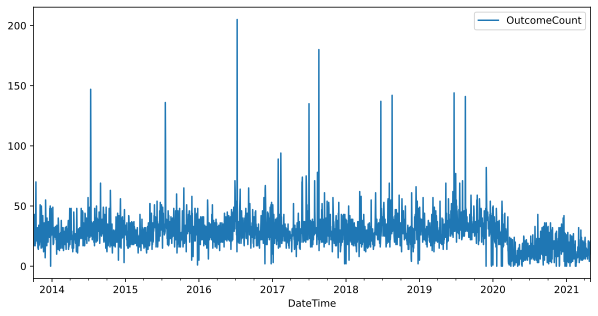

In [ ]:
# plotar gráfico diário
fig, ax = plt.subplots(figsize=(10, 5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

Ao visualizar o gráfico diário, notamos alguns picos, por volta do meio do ano, provavelmente por se tratar do feriado de 04 de julho nos Estados Unidos.

Vemos também que há uma queda no número de adoções no início de 2020, muito provavelmente impactado pela pandemia de COVID-19 que teve início em março/2020.

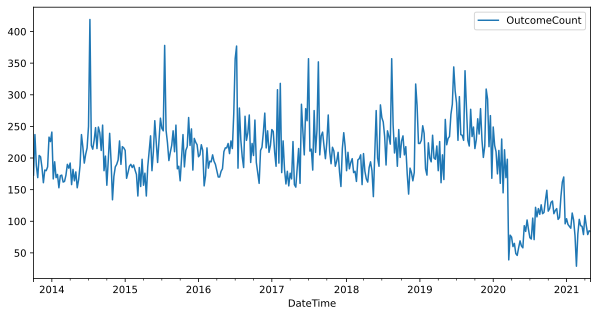

In [ ]:
# plotar gráfico semanal
fig, ax = plt.subplots(figsize=(10, 5))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()

No gráfico semanal vemos o mesmo comportamento do gráfico diário.

## Preparar os dados para o Prophet

Segundo a documentação, para que seja possível criar o modelo de *forecasting* com o Prophet precisamos que o *DataFrame* possua 2 colunas **DS** e **Y**, onde **DS** representa a data e **Y** o resultado.

Portanto iremos criar um novo *DataFrame* a partir de `adoptions_df` com as colunas renomeadas. Também iremos "resetar" o índice para o formato que o Prophet aceita.

Como criamos a coluna auxiliar *OutcomeCount* anteriormente, podemos agrupar os dados por data e utilizar o método `sum()`, assim teremos nosso **Y** representando o total de desfechos (*Adoption e Return to Owner*) e ocorridos na referida data.

O *DataFrame* deverá ficar semelhante a:

In [ ]:
# trabalhar com dados diários
# ds - DateTime
# y - OutcomeCount
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime': 'ds', 'OutcomeCount': 'y'})

# ver as 5 primeiras entradas
prophet_df.head()

,ds,y
0,2013-10-01,24
1,2013-10-02,27
2,2013-10-03,17
3,2013-10-04,20
4,2013-10-05,43


## Criar o Modelo de *Forecasting*

Nesse projeto iremos criar dois modelos de *forecasting* - um diário e outro semanal.

Ambos os modelos levarão em consideração os feriados dos Estados Unidos.

### Modelo Diário

Para o modelo diário iremos utilizar o *DataFrame* `prophet_df` que consiste nos dados de adoção agrupados por dia `resample('D')`.

In [ ]:
# instanciar e treinar o modelo
daily_model = Prophet()
daily_model.add_country_holidays(country_name='US')

daily_model.fit(prophet_df)

# determinar o período de dias para previsão
daily_future = daily_model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
daily_forecast = daily_model.predict(daily_future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


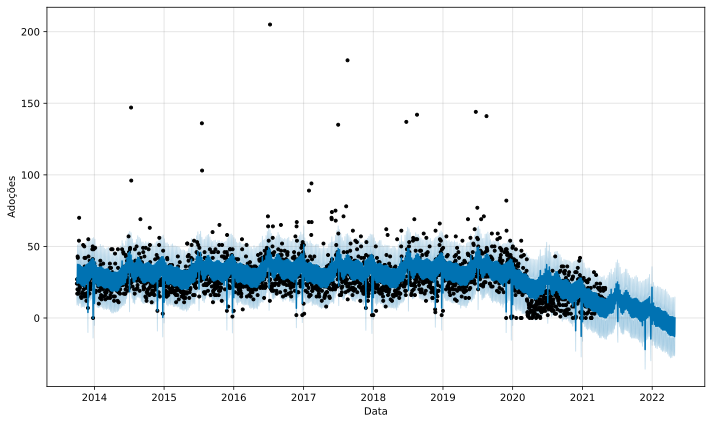

In [ ]:
# visualizar o gráfico com as previsões
daily_model.plot(daily_forecast, xlabel='Data', ylabel='Adoções');

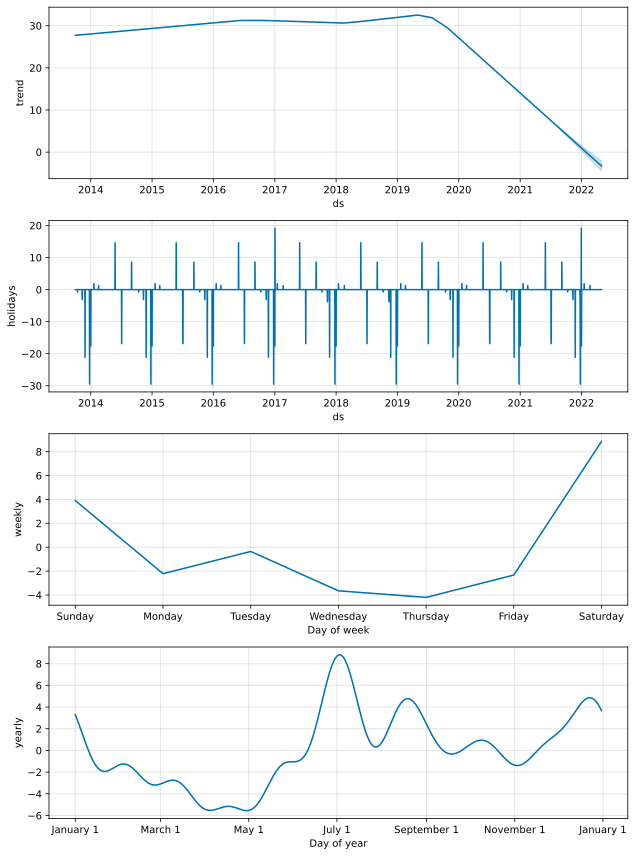

In [ ]:
# separar os componentes do modelo
daily_model.plot_components(daily_forecast);

Ao separar os components do modelo, conseguimos alguns insights referentes ao *dataset*:

1.  O volume de adoções é maior aos finais de semana e menor na quinta-feira;
2.  Anualmente, vemos um pico de adoções em julho;
3.  Vemos também que houve uma tendência de crescimento até 2019 seguido de uma queda abrupta em 2020 e adiante.

### Modelo Semanal

Para o modelo semanal iremos criar um novo *DataFrame* derivado de `adoptions_df` utilizando o método `resample('W')` que irá agrupar os dados por semana.

In [ ]:
# criar um modelo baseado em semanas
weekly_prophet_df = adoptions_df.resample('W').sum().reset_index().rename(columns={'DateTime': 'ds', 'OutcomeCount': 'y'})

# instanciar e treinar o modelo
weekly_model = Prophet()
weekly_model.add_country_holidays(country_name='US')
weekly_model.fit(weekly_prophet_df)

# determinar o período de dias para previsão
weekly_future = weekly_model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
weekly_forecast = weekly_model.predict(weekly_future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


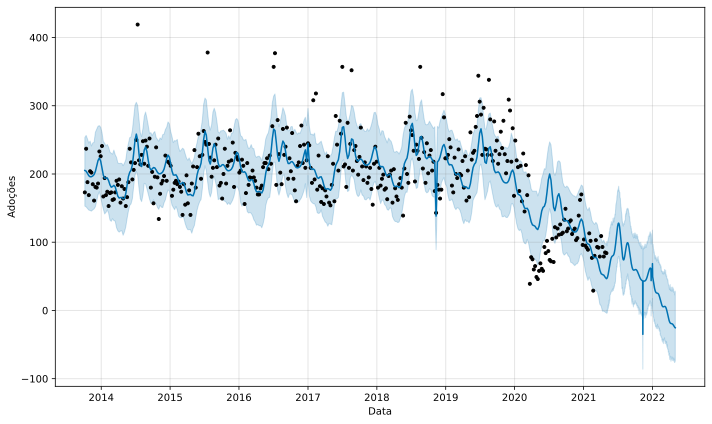

In [ ]:
# visualizar o gráfico com as previsões
weekly_model.plot(weekly_forecast, xlabel='Data', ylabel='Adoções');

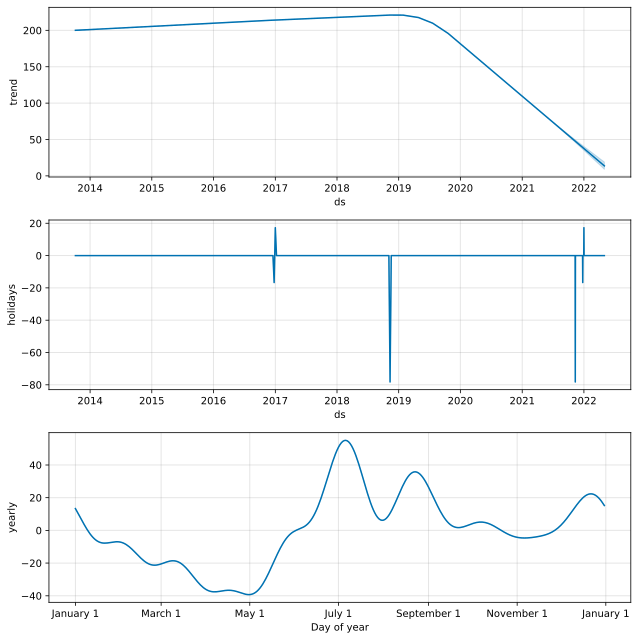

In [ ]:
weekly_model.plot_components(weekly_forecast);

No modelo semanal notamos o mesmo comportamento daquele visto no modelo diário:
tendência de alta até 2019 seguido de queda em 2020/2021

## Avaliação do modelo de séries Temporais

Com os modelos criados e treinados, precisamos avaliar seu desempenho, de modo que possamos saber se estão eficientes ou não.

Para avaliar nossos modelos iremos, primeiramente criar um novo *DataFrame* utilizando a função `cross_validation` do próprio ***Prophet*** utilizando um horizonte de 180 dias `horizon='180 days'`.

A partir desse *DataFrame* iremos extrair as métricas de desempenho utilizando a função `performance_metrics` e ilustraremos essas métricas através da função `plot_cross_validation_metric`.



### Modelo Diário


In [ ]:
# criar dataframe de cross_validation
daily_df_cv = cross_validation(daily_model, horizon='180 days')
daily_df_cv.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-06-01 00:00:00 and 2020-11-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-06-02,29.322890,19.022912,40.128221,16,2015-06-01
1,2015-06-03,27.291331,16.612632,38.181985,35,2015-06-01
2,2015-06-04,26.268453,16.240745,37.832412,32,2015-06-01
3,2015-06-05,26.867175,16.630527,37.223789,24,2015-06-01
4,2015-06-06,40.021120,29.595250,50.648948,28,2015-06-01


In [ ]:
# extrair métricas de desempenho
daily_df_p = performance_metrics(daily_df_cv)
daily_df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,18 days,158.874169,12.604530,8.460891,0.218993,0.814010
1,19 days,157.022610,12.530866,8.402753,0.211464,0.811594
2,20 days,163.951983,12.804374,8.644780,0.218899,0.806763
3,21 days,157.635535,12.555299,8.388382,0.203582,0.821256
4,22 days,135.691724,11.648679,8.148659,0.205023,0.833333


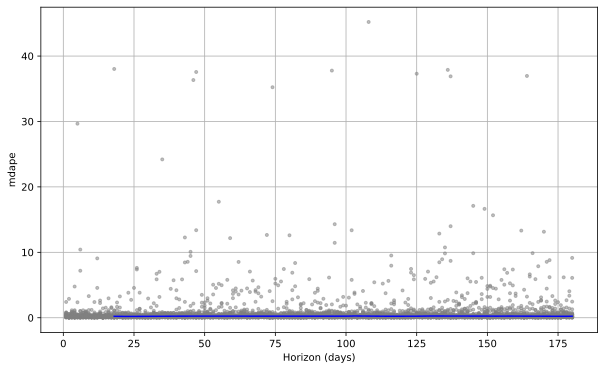

In [ ]:
# plotar gráfico
fig = plot_cross_validation_metric(daily_df_cv, metric='mdape')

### Modelo Semanal

In [ ]:
weekly_df_cv = cross_validation(weekly_model, horizon='180 days')
weekly_df_cv.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2015-06-03 00:00:00 and 2020-11-03 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-06-07,223.895922,193.387997,254.482980,226,2015-06-03
1,2015-06-14,205.404123,172.550957,238.322718,193,2015-06-03
2,2015-06-21,202.521811,169.725397,234.581811,228,2015-06-03
3,2015-06-28,233.152633,201.079496,262.739705,263,2015-06-03
4,2015-07-05,281.873642,251.762979,315.153098,247,2015-06-03


In [ ]:
weekly_df_p = performance_metrics(weekly_df_cv)
weekly_df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,2485.690294,49.856698,36.287985,0.270446,0.125901,0.677966
1,19 days,2431.017632,49.305351,35.568775,0.265944,0.115334,0.689266
2,20 days,2126.775864,46.116980,32.166776,0.239251,0.110826,0.728814
3,21 days,1822.303663,42.688449,29.975603,0.214563,0.110257,0.754237
4,22 days,1885.515732,43.422526,30.136407,0.209514,0.107315,0.762712


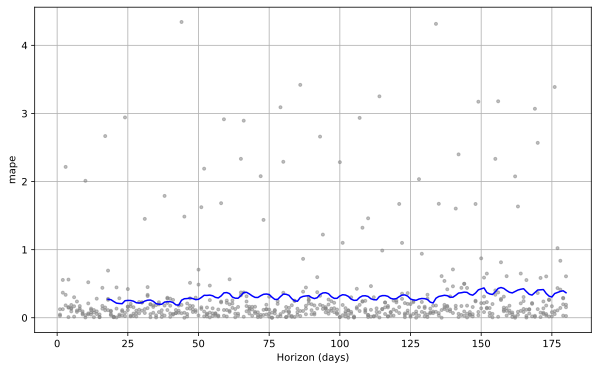

In [ ]:
weekly_fig = plot_cross_validation_metric(weekly_df_cv, metric='mape')

## Conclusão

Conforme os dados e gráficos expostos ao longo desse projeto, notamos que o feriado de 4 de julho impulsiona o número de adoções de animais, mostrando que pode ser interessante a realização de campanhas para otimizar as adoções.

Notamos também que em maio não há volume elevado de adoções, sendo, provavelmente um período importante para aquisição de insumos.

Também podemos perceber que este foi um setor diretamente impactado pela pandemia de COVID-19 - e o consequente isolamento social - visto que a partir de 2020, houve uma queda brusca no número de desfechos positivos.

### Melhorias e projetos futuros

Como propostas de melhorias e projetos futuros temos:
* Melhorar o desempenho dos modelos considerando apenas os dados anteriores ao início;
* Realizar análise considerando apenas os dados após o início pandemia;
* Realizar análise comparativa entre os períodos pré e durante a pandemia.

## Referências

Taylor SJ, Letham B. 2017. Forecasting at scale. PeerJ Preprints 5:e3190v2 

https://doi.org/10.7287/peerj.preprints.3190v2